# Lab2 : k-Nearest Neighbor (kNN) Implementation

You're required to implement kNN classifier from scratch, it's simple and easy.

To understand the k nearest neighbor, check the following video

https://www.youtube.com/watch?v=4ObVzTuFivY

Some of the following codes are copied from CS231n assignment1 notebooks


#### Important

For the notebook to work properly and for it to be able to load the cifar-10 dataset, you need to download the dataset from here : http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

Then extract downloaded dataset to the folder 'cifar-10-batches-py', in the same directory with this notebook, this folder should contain the dataset files directly.

so the hierarchy should be
- cifar-10-batches-py
    - batches.meta
    - data_batch_1
    - etc
- data_utils.py
- knn.ipynb
- imgs

In [4]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import pickle


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

('Training data shape: ', (50000, 32, 32, 3))
('Training labels shape: ', (50000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


In [6]:
# Subsample the data for more efficient code execution in this exercise and for the data to fit in memory
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]



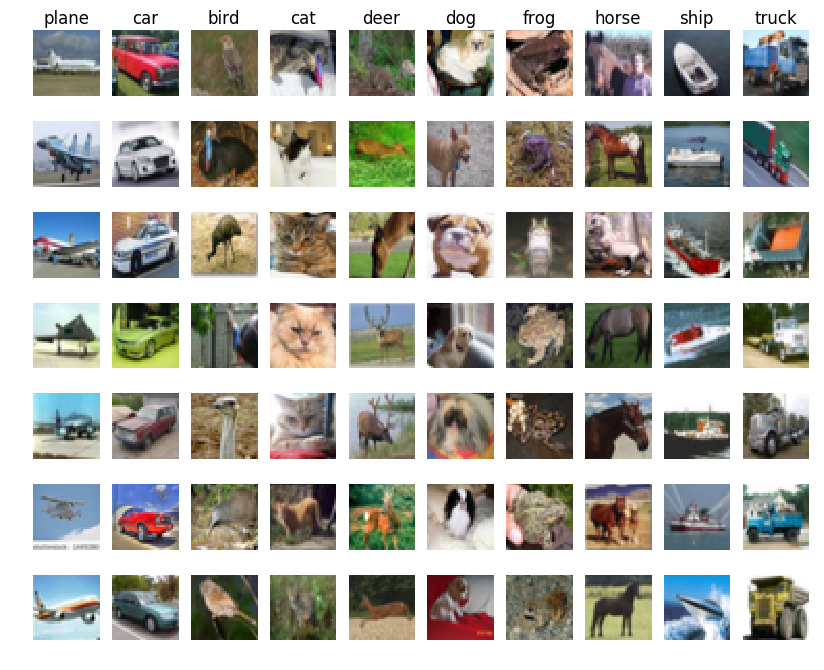

In [8]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

showing the second image
ground truth class =  truck


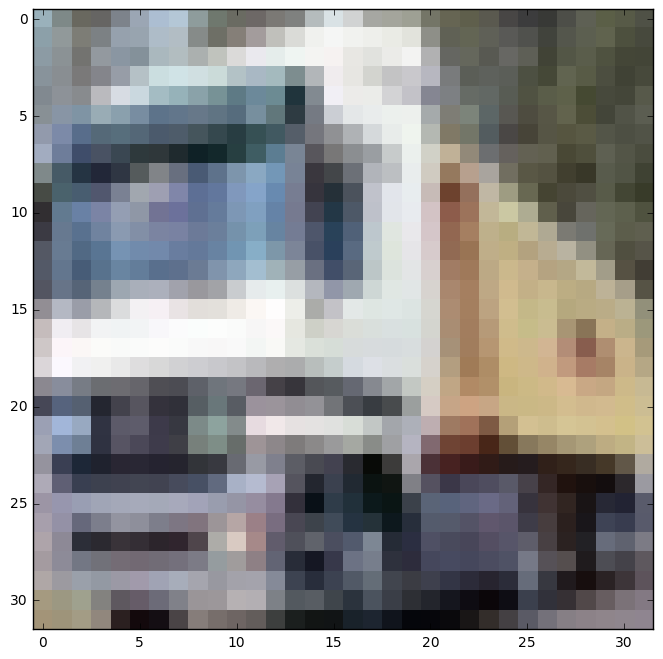

In [9]:
print "showing the second image"
print "ground truth class = ",classes[y_train[1]]
plt.imshow(X_train[1].astype('uint8'))


## how to compute the distance between images

One way to compute the distance between two matrices (images) is to do the following
<img src="imgs/absdiff.jpeg" height="400" width = "800" >

We won't use the above method, instead we'll compute the square root of the sum of square difference
- C = A - B
- C = C power 2
- C = np.sum(C)
- result = np.sqrt(C)

this can be done using

distance = np.sqrt(np.sum(np.square(A-B)))

In [10]:
# Reshape the image data into rows to easily manipulate them.
print X_train.shape, X_test.shape
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape
print len(X_test),len(X_train)

(5000, 32, 32, 3) (500, 32, 32, 3)
(5000, 3072) (500, 3072)
500 5000


In [18]:
"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [19]:
import random
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential # both used for defining  the networks
from keras.layers.core import Dense, Activation # defining the layers
from keras.optimizers import RMSprop, SGD
from keras.utils import np_utils
from keras import backend as K
# IMAGE ORDERING: Tensorflow(64,64,3), Theano(3,64,64)
K.set_image_dim_ordering('tf') # always check you are using the correct image dimension
import matplotlib.pyplot as plt
%matplotlib inline



ValueError: too many values to unpack

### Different choices of K produce different classifiers

To understand the following image:

- The left image represent the input data to be classifier, each data point color represents its ***ground truth** class.

- In the middle and right images the backgroud color is the class that all the points within  this background will be classified to, you notice that in the right image, some parts have white background and this means that the knn classifier can't decide to which class this region belongs due to there're two neighbors of class x and two other neighbors of class y for in the whole area that has a white background.

- You can notice that increasing k makes the decision boundary more smooth and more robust to weird input distribution (a random red point that might be noisy inside a region that's full of blue points).

- The middle and right images are called **Decision Boundary**, it's important to know what's the expected decision boundary shape of all machine learning models that you'll know.

In the following labs, we'll understand how to decide the optimal number of neighbors to use.


***ground truth** is the class label that was decided by the human observer, we compare against the ground truth to measure how successful our machine learning model is

<img src="imgs/knn2.jpeg" height="400" width = "800" >

In [12]:
## compute accuracy --> how many test images has been correctly classifier / how many test images

## using k = 1 --> use only the nearest neighbor to decide



## accuracy for k = 1 should be 27%

## using k = 5 --> use the 5 nearest neighbors to decide which class (harder)

## you'll need the following function, if you've a list and you need to know which element
## was repeated the most use the following
from scipy import stats

arr = np.array([[1,2,3,4,5,5],[4,3,3,2,5,5]])

print stats.mode(arr,axis = 1) #--> 
print stats.mode(arr,axis = 1)[0][0] # most repeated element in the first row
print stats.mode(arr,axis = 1)[0][1] # most repeated element in the second row
print stats.mode(arr,axis = 1)[1][0] # repetition count of the most repeated element in the first row

## also check the following function output
## it produces the indices that can sort the array 
print np.argsort(arr) 


ModeResult(mode=array([[5],
       [3]]), count=array([[2],
       [2]]))
[5]
[3]
[2]
[[0 1 2 3 4 5]
 [3 1 2 0 4 5]]


### Why K-Nearest Neighbor on pixel level isn't perfect for image classification?

All the following images has the same distance from the left most image

<img src="imgs/knn3.png" height="400" width = "800" >

Pixel-based distances on high-dimensional data (and images especially) can be very unintuitive. An original image (left) and three other images next to it that are all equally far away from it based on L2 pixel distance. Clearly, the pixel-wise distance does not correspond at all to perceptual or semantic similarity.

#### In the following labs we'll explore how deep neural networks are capable of boosting our accuracy.